In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


In [2]:
%matplotlib notebook

In [6]:
# meta data
z = 0.00888
tb_max = 58863.9

In [3]:
lc_df = pd.read_hdf('/Users/adamamiller/astronomy/ZTF/SN19yvq/data/P48/SN2019yvq/data/photometry/P48/forcephot_product/lightcurves/ZTF19adcecwu_force_phot_nob.h5')

In [39]:
SNT=5
Fratio = lc_df["Fratio"].values
Fratio_unc = lc_df["Fratio_unc"].values
ix = Fratio > SNT*Fratio_unc


mags = -2.5 * np.log10(Fratio[ix])
emags = 2.5 / np.log(10) * Fratio_unc[ix] / Fratio[ix]
filt_id = lc_df.filterid.values

ulims = -2.5*np.log10(5*Fratio_unc[~ix])

<IPython.core.display.Javascript object>


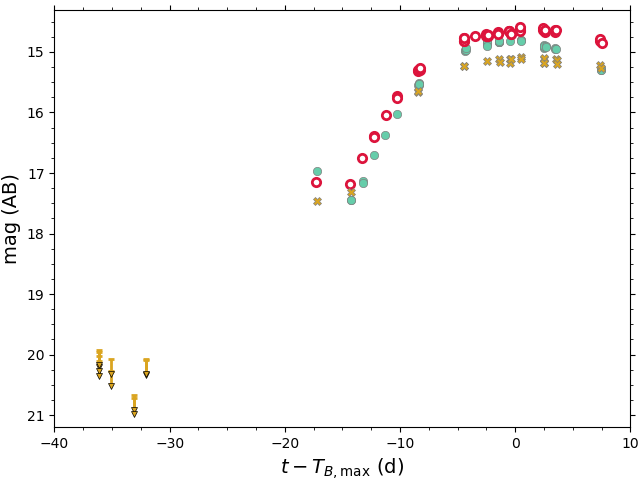

In [60]:
color_dict = {1: 'MediumAquaMarine',
              2: 'Crimson', 
              3: 'Goldenrod'}

mark_color_dict = {2: 'white',
                   1: 'MediumAquaMarine',
                   3: 'Goldenrod'}
sym_dict = {1: 'o',
            2: 'o',
            3: 'X'}
mec_dict = {2: 'Crimson',
            1: '0.5',
            3: '0.5'}
mew_dict = {2: 2,
            1: 0.5,
            3: 0.5}
filt_dict = {1: b'g', 2: b'r'}

fig, ax = plt.subplots()

for filt in [1,2,3]:
    mag_filt = np.where(filt_id[ix] == filt)
    ax.errorbar((lc_df.jdobs.iloc[ix].values[mag_filt] - 2400000.5 - tb_max)/(1+z), 
                mags[mag_filt], emags[mag_filt], 
                fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                mec=mec_dict[filt], mew=mew_dict[filt])

    
    ulim_filt = np.where(filt_id[~ix] == filt)
    ULoffset = 0.25
    yerr = np.zeros((2, len(ulim_filt[0])))
    yerr[0,:] += ULoffset
    ax.errorbar((lc_df.jdobs.iloc[~ix].values[ulim_filt] - 2400000.5 - tb_max)/(1+z), 
                ulims[ulim_filt]+ULoffset, yerr = yerr, 
                fmt = 'v', color = color_dict[filt], ms = 5, 
                elinewidth=2, capsize = 0, mec = 'k', mew = 0.5)
    ax.plot((lc_df.jdobs.iloc[~ix].values[ulim_filt] - 2400000.5 - tb_max)/(1+z), 
            ulims[ulim_filt], '_', 
            color = color_dict[filt], mew = 2, ms = 5)
    
    
    
#     ax.errorbar((lc_df.jdobs.iloc[~ix].values[ulim_filt] - 2400000.5 - tb_max)/(1+z), 
#                 ulims[ulim_filt],
#                 fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
#                 mec=mec_dict[filt], mew=mew_dict[filt])
    

ax.set_ylim(21.2,14.3)
ax.set_xlim((-40,10))
ax.set_xlabel(r'$t - T_{B,\mathrm{max}}$ (d)', fontsize=14)
ax.set_ylabel(r'mag (AB)', fontsize=14)
ax.xaxis.set_minor_locator(MultipleLocator(2.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(which='both', top=True,right=True)

fig.subplots_adjust(left=0.085, bottom=0.11,top=0.98,right=0.985)
fig.savefig('../paper/figures/P48_lc.pdf')